In [1]:
import seaborn as sns
import folium
import geopandas as gpd
import pandas as pd
from logging import warning

from utils.downloads import (
    Censo,
    Nivel,
    download_malha
)

In [2]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

# Índice de impureza de Gini

O índice de impureza de Gini (em homenagem ao matemático italiano Corrado Gini) é uma medida de quantas vezes um elemento escolhido aleatoriamente do conjunto seria rotulado incorretamente se fosse rotulado aleatoriamente de acordo com o distribuição de rótulos no subconjunto.

A impureza Gini pode ser calculada somando a probabilidade $p_{j}$ de um item com etiqueta $j$ ser escolhido vezes a probabilidade $\sum _{k\neq j}p_{k}=1-p_{j}$ de um erro na categorização desse item.

Ele atinge seu mínimo (zero) quando todos os casos no nó caem em uma única categoria de destino.

Para calcular a impureza Gini para um conjunto de itens com $J$ classes, suponha $j\in \{1,2,...,J\}$, e considere a fração $p_{j}$ de itens rotulados com classe $j$ no conjunto.

$$ \text{I}_{G}(p)=\sum _{j=1}^{J}\left(p_{j}\sum_{k\neq j}p_{k}\right)=\sum_{j=1}^{J}p_{j}(1-p_{j})=\sum_{j=1}^{J}(p_{j}-{p_{j}}^{2})=\sum_{j=1}^{J}p_{j}-\sum_{j=1}^{J}{p_{j}}^{2}=1-\sum_{j=1}^{J}{p_{j}}^{2}$$


Adaptando ao nosso contexto, consideramos que cada setor censitário de 2022 é composto por $J$ setores censitários de 2010, e que a probabilidade de classificação correta $p_j$ seja equivalente à similaridade do setor censitário de 2022 e um dado setor censitário de 2010.and

Assim, conseguimos avaliar a impureza de cada um dos setores censitários de 2022 com base na sua composição.


Além disso, podemos utilizar o índice de impureza de Gini como métrica para avaliar o ganho de qualidade nos dados relativo a cada um dos tratamentos realizados.

# Carregando os dados

Primeiro, vamos carregar os dados básicos dos setores censitários de 2022 e os dados de similaridade gerados nos notebooks anteriores.

In [3]:
%%time
setores22 = download_malha(Censo.CENSO_2022, Nivel.SETORES)
setores22 = setores22[setores22['CD_MUN'] == '3550308']
setores22 = setores22.to_crs(epsg=31983)
setores22.sample(3)

CPU times: user 1min 7s, sys: 505 ms, total: 1min 7s
Wall time: 1min 15s


,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,CD_CONCURB,NM_CONCURB,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry
91305,355030890000202P,0.003548,3,Sudeste,35,São Paulo,3550308,São Paulo,355030890,Vila Mariana,...,3550308,São Paulo/SP,220,119,119,0,2.075472,11.320755,106,"POLYGON ((331862.613 7392243.402, 331824.563 7..."
78923,355030843000923P,0.010968,3,Sudeste,35,São Paulo,3550308,São Paulo,355030843,Jardim Ângela,...,3550308,São Paulo/SP,741,453,453,0,2.754647,4.832714,269,"POLYGON ((320114.632 7380671.017, 320109.532 7..."
84367,355030864000093P,0.029745,3,Sudeste,35,São Paulo,3550308,São Paulo,355030864,Ponte Rasa,...,3550308,São Paulo/SP,439,159,159,0,2.907285,7.284768,151,"POLYGON ((346912.252 7399411.318, 346897.057 7..."


In [4]:
sim_22_path = 'data/01_similarity.parquet'
sim_22 = gpd.read_parquet(sim_22_path)
sim_22

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
0,355030801000001P,355030801000001,"POLYGON ((339784.892 7392592.542, 339764.035 7...",70930.590833,9.880993e-01
1,355030801000001P,355030801000006,"MULTIPOLYGON (((339819.409 7392592.743, 339784...",373.279509,5.199974e-03
2,355030801000001P,355030801000010,"POLYGON ((339617.259 7392754.613, 339531.109 7...",9.240690,1.287275e-04
3,355030801000001P,355030801000011,"POLYGON ((339777.790 7392945.533, 339661.597 7...",471.770933,6.572010e-03
4,355030801000002P,355030801000001,"POLYGON ((339814.260 7392989.900, 339811.966 7...",18.451154,2.566574e-04
...,...,...,...,...,...
114396,355030896000338P,355030896000104,"POLYGON ((355756.807 7397691.040, 355771.483 7...",33668.997801,9.873096e-01
114397,355030896000339P,355030884000164,"POLYGON ((355953.783 7397535.061, 355931.532 7...",0.003980,3.971344e-07
114398,355030896000339P,355030896000044,"MULTIPOLYGON (((355945.903 7397487.853, 355937...",2.775304,2.769267e-04
114399,355030896000339P,355030896000103,"MULTIPOLYGON (((355820.955 7397537.877, 355825...",6952.030517,6.936909e-01


In [5]:
sim_viario_22_path = 'data/02_similarity_viario.parquet'
sim_viario_22 = gpd.read_parquet(sim_viario_22_path)
sim_viario_22

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
0,355030801000001P,355030801000001,"MULTIPOLYGON (((339697.627 7392669.185, 339729...",60142.847118,9.992098e-01
1,355030801000001P,355030801000006,"POLYGON ((339710.043 7392605.568, 339708.368 7...",47.562187,7.901954e-04
2,355030801000002P,355030801000002,"MULTIPOLYGON (((339956.877 7392696.391, 339946...",61038.586717,9.917982e-01
3,355030801000002P,355030801000004,"MULTIPOLYGON (((339896.485 7392687.569, 339899...",504.763397,8.201754e-03
4,355030801000003P,355030801000002,"MULTIPOLYGON (((339914.451 7392695.424, 339915...",242.683018,5.273030e-03
...,...,...,...,...,...
87836,355030896000338P,355030896000103,"MULTIPOLYGON (((355571.242 7397650.138, 355571...",122.522044,4.579846e-03
87837,355030896000338P,355030896000104,"MULTIPOLYGON (((355712.152 7397608.612, 355714...",26629.910122,9.954200e-01
87838,355030896000339P,355030896000044,"POLYGON ((355968.423 7397510.399, 355967.757 7...",0.000118,1.353077e-08
87839,355030896000339P,355030896000103,"MULTIPOLYGON (((355968.843 7397509.296, 355968...",5789.638008,6.655116e-01


In [6]:
sim_double_buff_22_path = 'data/06_similarity_double_buffer.parquet'
sim_double_buff_22 = gpd.read_parquet(sim_double_buff_22_path)
sim_double_buff_22

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
43400,355030801000001P,355030801000001,"MULTIPOLYGON (((339726.534 7392638.425, 339726...",54797.963347,1.000000
43401,355030801000002P,355030801000002,"MULTIPOLYGON (((339823.766 7392951.574, 339815...",56717.891680,0.999637
43403,355030801000002P,355030801000004,"POLYGON ((339823.766 7392951.574, 339825.861 7...",20.574768,0.000363
43401,355030801000003P,355030801000002,"POLYGON ((340063.467 7392874.480, 340063.496 7...",0.222867,0.000005
43402,355030801000003P,355030801000003,"MULTIPOLYGON (((340064.376 7392879.276, 340066...",41689.754272,0.999983
...,...,...,...,...,...
62367,355030896000337P,355030896000230,"POLYGON ((354261.180 7397329.839, 354257.310 7...",123.828312,0.002243
62240,355030896000338P,355030896000103,"POLYGON ((355570.830 7397714.789, 355571.654 7...",22.538290,0.000957
62241,355030896000338P,355030896000104,"MULTIPOLYGON (((355570.830 7397714.789, 355571...",23517.477521,0.999043
62240,355030896000339P,355030896000103,"MULTIPOLYGON (((355573.355 7397638.607, 355572...",5030.809286,0.730378


In [7]:
sim_double_buff_resga_22_path = 'data/06_similarity_double_buffer_resga.parquet'
sim_double_buff_resga_22 = gpd.read_parquet(sim_double_buff_resga_22_path)
sim_double_buff_resga_22

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
43400,355030801000001P,355030801000001,"MULTIPOLYGON (((339726.440 7392638.031, 339726...",54797.963347,1.000000
43401,355030801000002P,355030801000002,"MULTIPOLYGON (((339823.766 7392951.574, 339815...",56717.891680,0.999637
43403,355030801000002P,355030801000004,"POLYGON ((339823.766 7392951.574, 339825.861 7...",20.574768,0.000363
43401,355030801000003P,355030801000002,"POLYGON ((340063.467 7392874.480, 340063.496 7...",0.222867,0.000005
43402,355030801000003P,355030801000003,"MULTIPOLYGON (((340064.376 7392879.276, 340066...",41689.754272,0.999983
...,...,...,...,...,...
62367,355030896000337P,355030896000230,"POLYGON ((354261.180 7397329.839, 354257.310 7...",123.828312,0.002243
62240,355030896000338P,355030896000103,"POLYGON ((355570.830 7397714.789, 355571.654 7...",22.538290,0.000957
62241,355030896000338P,355030896000104,"MULTIPOLYGON (((355570.830 7397714.789, 355571...",23517.477521,0.999043
62240,355030896000339P,355030896000103,"MULTIPOLYGON (((355573.355 7397638.607, 355572...",5030.809286,0.730378


In [8]:
%%time
setores10 = download_malha(Censo.CENSO_2010, Nivel.SETORES)
setores10 = setores10[setores10['CD_GEOCODM'] == '3550308']
setores10 = setores10.to_crs(epsg=31983)
setores10.sample(3)

CPU times: user 17.9 s, sys: 893 ms, total: 18.8 s
Wall time: 20.8 s


,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry
44588,110170.0,355030811000261,RURAL,35503081100,None,355030811,BRASILÂNDIA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,44589,"POLYGON ((325824.990 7406337.442, 325932.108 7..."
55152,120691.0,355030859000197,URBANO,35503085900,None,355030859,PENHA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,55153,"POLYGON ((343795.760 7397754.011, 343803.714 7..."
55373,120927.0,355030861000009,URBANO,35503086100,None,355030861,PERUS,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,55374,"POLYGON ((320215.212 7410163.087, 320214.679 7..."


# Calculando o índice

In [9]:
def gini_impurity(df:pd.DataFrame, prob_col:str='inter_perc', precision:int=5) -> float:
    prob_sum = round(df[prob_col].sum(), precision)
    if prob_sum != 1:
        warning(f'A soma das probabilidades do setor {df.iloc[0,0]} ({prob_sum}) é diferente de 1')
        if df.shape[0]==1:
            warning('Como ele possui interseção com apenas um setor, sua impureza foi arrendodada para 0')
            return 0
    return round(1-(df[prob_col]**2).sum(), precision)

In [10]:
def row_gini_impurity(row_id:str, other_df:gpd.GeoDataFrame, id_col:str='CD_SETOR', prob_col:str='inter_perc', precision:int=5) -> float:
    filtered_df = other_df.query(f'{id_col} == "{row_id}"')
    if filtered_df.shape[0] < 1:
        warning(f'O setor {row_id} não possui similaridade com nenhum setor de 2010')
        return 0
    return gini_impurity(filtered_df, prob_col, precision)    

In [11]:
%%time
setores22['Gini_base'] = setores22['CD_SETOR'].apply(lambda r: row_gini_impurity(r, sim_22))
setores22

CPU times: user 1min 39s, sys: 407 ms, total: 1min 39s
Wall time: 1min 40s


,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,NM_CONCURB,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry,Gini_base
65763,355030801000001P,0.071797,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,São Paulo/SP,682,329,329,0,2.359862,3.806228,289,"POLYGON ((339819.409 7392592.743, 339817.380 7...",0.02359
65764,355030801000002P,0.071902,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,São Paulo/SP,1374,1011,1011,0,2.293823,1.502504,599,"POLYGON ((339965.618 7393034.241, 339934.552 7...",0.05430
65765,355030801000003P,0.055681,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,São Paulo/SP,557,239,238,1,2.673171,9.268293,205,"POLYGON ((340157.893 7392942.288, 340105.133 7...",0.07598
65766,355030801000004P,0.064905,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,São Paulo/SP,526,245,245,0,2.380090,1.357466,221,"POLYGON ((339898.252 7392661.977, 339885.527 7...",0.09299
65767,355030801000005P,0.086820,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,São Paulo/SP,579,258,258,0,2.619910,9.049774,221,"POLYGON ((339650.828 7392494.453, 339535.589 7...",0.15892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93350,355030896000335P,0.073741,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,São Paulo/SP,0,0,0,0,0.000000,0.000000,0,"POLYGON ((354132.481 7397368.586, 354125.016 7...",0.03266
93351,355030896000336P,0.031251,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,São Paulo/SP,604,236,236,0,2.960784,11.764706,204,"POLYGON ((354471.914 7396849.101, 354434.862 7...",0.14669
93352,355030896000337P,0.061406,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,São Paulo/SP,0,0,0,0,0.000000,0.000000,0,"POLYGON ((354680.264 7397460.478, 354562.385 7...",0.19695
93353,355030896000338P,0.034111,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,São Paulo/SP,464,164,164,0,3.052632,19.736842,152,"POLYGON ((355571.348 7397734.893, 355565.065 7...",0.02506


In [12]:
%%time
setores22['Gini_V'] = setores22['CD_SETOR'].apply(lambda r: row_gini_impurity(r, sim_viario_22))
setores22

CPU times: user 1min 25s, sys: 181 ms, total: 1min 25s
Wall time: 1min 25s


,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry,Gini_base,Gini_V
65763,355030801000001P,0.071797,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,682,329,329,0,2.359862,3.806228,289,"POLYGON ((339819.409 7392592.743, 339817.380 7...",0.02359,0.00158
65764,355030801000002P,0.071902,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,1374,1011,1011,0,2.293823,1.502504,599,"POLYGON ((339965.618 7393034.241, 339934.552 7...",0.05430,0.01627
65765,355030801000003P,0.055681,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,557,239,238,1,2.673171,9.268293,205,"POLYGON ((340157.893 7392942.288, 340105.133 7...",0.07598,0.01886
65766,355030801000004P,0.064905,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,526,245,245,0,2.380090,1.357466,221,"POLYGON ((339898.252 7392661.977, 339885.527 7...",0.09299,0.03326
65767,355030801000005P,0.086820,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,579,258,258,0,2.619910,9.049774,221,"POLYGON ((339650.828 7392494.453, 339535.589 7...",0.15892,0.08442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93350,355030896000335P,0.073741,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,0,0,0,0,0.000000,0.000000,0,"POLYGON ((354132.481 7397368.586, 354125.016 7...",0.03266,0.03385
93351,355030896000336P,0.031251,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,604,236,236,0,2.960784,11.764706,204,"POLYGON ((354471.914 7396849.101, 354434.862 7...",0.14669,0.17425
93352,355030896000337P,0.061406,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,0,0,0,0,0.000000,0.000000,0,"POLYGON ((354680.264 7397460.478, 354562.385 7...",0.19695,0.19828
93353,355030896000338P,0.034111,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,464,164,164,0,3.052632,19.736842,152,"POLYGON ((355571.348 7397734.893, 355565.065 7...",0.02506,0.00912


In [13]:
%%time
setores22['Gini_DB'] = setores22['CD_SETOR'].apply(lambda r: row_gini_impurity(r, sim_double_buff_22))
setores22

CPU times: user 1min 4s, sys: 129 ms, total: 1min 5s
Wall time: 1min 5s


,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,v0002,v0003,v0004,v0005,v0006,v0007,geometry,Gini_base,Gini_V,Gini_DB
65763,355030801000001P,0.071797,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,329,329,0,2.359862,3.806228,289,"POLYGON ((339819.409 7392592.743, 339817.380 7...",0.02359,0.00158,-0.00000
65764,355030801000002P,0.071902,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,1011,1011,0,2.293823,1.502504,599,"POLYGON ((339965.618 7393034.241, 339934.552 7...",0.05430,0.01627,0.00072
65765,355030801000003P,0.055681,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,239,238,1,2.673171,9.268293,205,"POLYGON ((340157.893 7392942.288, 340105.133 7...",0.07598,0.01886,0.00003
65766,355030801000004P,0.064905,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,245,245,0,2.380090,1.357466,221,"POLYGON ((339898.252 7392661.977, 339885.527 7...",0.09299,0.03326,0.00507
65767,355030801000005P,0.086820,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,258,258,0,2.619910,9.049774,221,"POLYGON ((339650.828 7392494.453, 339535.589 7...",0.15892,0.08442,0.04882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93350,355030896000335P,0.073741,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,0,0,0,0.000000,0.000000,0,"POLYGON ((354132.481 7397368.586, 354125.016 7...",0.03266,0.03385,0.02150
93351,355030896000336P,0.031251,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,236,236,0,2.960784,11.764706,204,"POLYGON ((354471.914 7396849.101, 354434.862 7...",0.14669,0.17425,0.15178
93352,355030896000337P,0.061406,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,0,0,0,0.000000,0.000000,0,"POLYGON ((354680.264 7397460.478, 354562.385 7...",0.19695,0.19828,0.17775
93353,355030896000338P,0.034111,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,164,164,0,3.052632,19.736842,152,"POLYGON ((355571.348 7397734.893, 355565.065 7...",0.02506,0.00912,0.00191


In [14]:
%%time
setores22['Gini_DBR'] = setores22['CD_SETOR'].apply(lambda r: row_gini_impurity(r, sim_double_buff_resga_22))
setores22

CPU times: user 1min 2s, sys: 62.1 ms, total: 1min 2s
Wall time: 1min 2s


,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,v0003,v0004,v0005,v0006,v0007,geometry,Gini_base,Gini_V,Gini_DB,Gini_DBR
65763,355030801000001P,0.071797,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,329,0,2.359862,3.806228,289,"POLYGON ((339819.409 7392592.743, 339817.380 7...",0.02359,0.00158,-0.00000,0.00000
65764,355030801000002P,0.071902,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,1011,0,2.293823,1.502504,599,"POLYGON ((339965.618 7393034.241, 339934.552 7...",0.05430,0.01627,0.00072,0.00072
65765,355030801000003P,0.055681,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,238,1,2.673171,9.268293,205,"POLYGON ((340157.893 7392942.288, 340105.133 7...",0.07598,0.01886,0.00003,0.00003
65766,355030801000004P,0.064905,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,245,0,2.380090,1.357466,221,"POLYGON ((339898.252 7392661.977, 339885.527 7...",0.09299,0.03326,0.00507,0.00507
65767,355030801000005P,0.086820,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,258,0,2.619910,9.049774,221,"POLYGON ((339650.828 7392494.453, 339535.589 7...",0.15892,0.08442,0.04882,0.04882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93350,355030896000335P,0.073741,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,0,0,0.000000,0.000000,0,"POLYGON ((354132.481 7397368.586, 354125.016 7...",0.03266,0.03385,0.02150,0.02150
93351,355030896000336P,0.031251,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,236,0,2.960784,11.764706,204,"POLYGON ((354471.914 7396849.101, 354434.862 7...",0.14669,0.17425,0.15178,0.15178
93352,355030896000337P,0.061406,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,0,0,0.000000,0.000000,0,"POLYGON ((354680.264 7397460.478, 354562.385 7...",0.19695,0.19828,0.17775,0.17775
93353,355030896000338P,0.034111,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,164,0,3.052632,19.736842,152,"POLYGON ((355571.348 7397734.893, 355565.065 7...",0.02506,0.00912,0.00191,0.00191


# Análise comparada dos índices

In [15]:
setores22[['Gini_base', 'Gini_V', 'Gini_DB', 'Gini_DBR']].describe()

,Gini_base,Gini_V,Gini_DB,Gini_DBR
count,27592.000000,27592.000000,27592.000000,27592.000000
mean,0.092752,0.081061,0.071914,0.071909
std,0.152059,0.150551,0.146583,0.146580
min,-0.000000,0.000000,0.000000,-0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.008540,0.001860,0.000000,0.000000
75%,0.114538,0.073350,0.046120,0.046120
max,0.816710,0.811010,0.804520,0.804510


No geral, as distribuições tiveram poucas mudanças, com a média e o desvio padrão bastante próximos.

Porém, as mudanças no Q3 e, no caso do Gini de base, na mediana se mostram bastante importantes.

Outro fato interessante é que o Gini máximo aumentou nas bases tratadas.

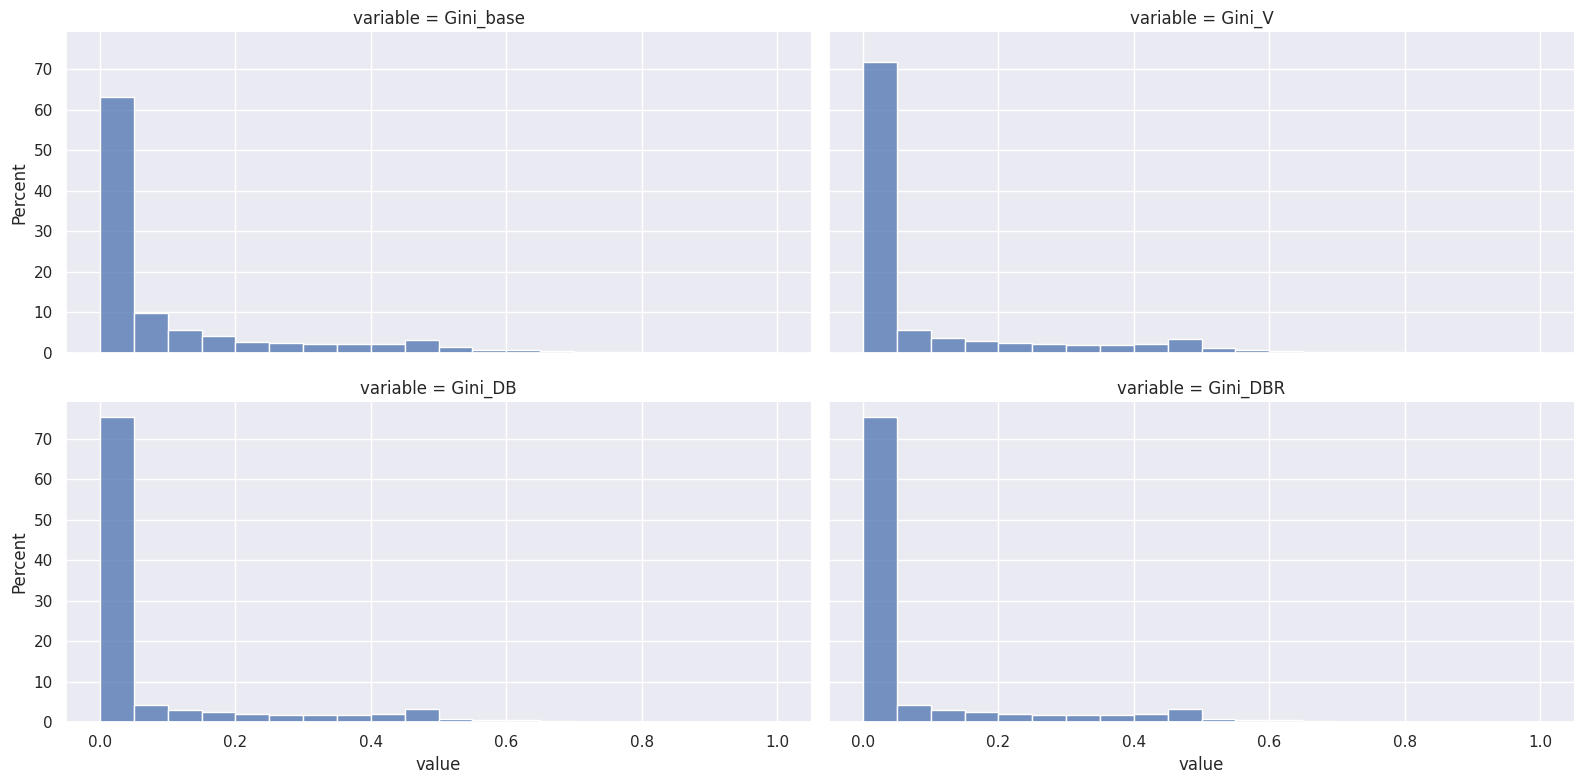

In [16]:
melted = setores22[['CD_SETOR', 'Gini_base', 'Gini_V', 'Gini_DB', 'Gini_DBR']].melt('CD_SETOR')
g = sns.FacetGrid(melted,
                  col="variable",
                  col_wrap=2,
                  height=4,
                  aspect=2)
g.map(sns.histplot, "value", stat='percent', bins=[b/100 for b in range(0, 105, 5)])


Os histogramas também corroboram com as impressões anteriores: as distribuições mantiveram seu formato geral semelhante, mas com uma nítida redução dos valores acima de 0,45.

Outro fato notável é o aumento da quantidade de índices até 0,05, que passa de aproximadamente 60% para pouco mais de 75%.

# Apresentação visual dos índices

In [17]:
setores22['Gini_base_centered'] = setores22['Gini_base']-setores22['Gini_base'].mean()

In [18]:
indexes = [
    ('Gini (Base)', 'Gini_base'),
    ('Gini (Recorte viário)', 'Gini_V')
]

<Axes: >

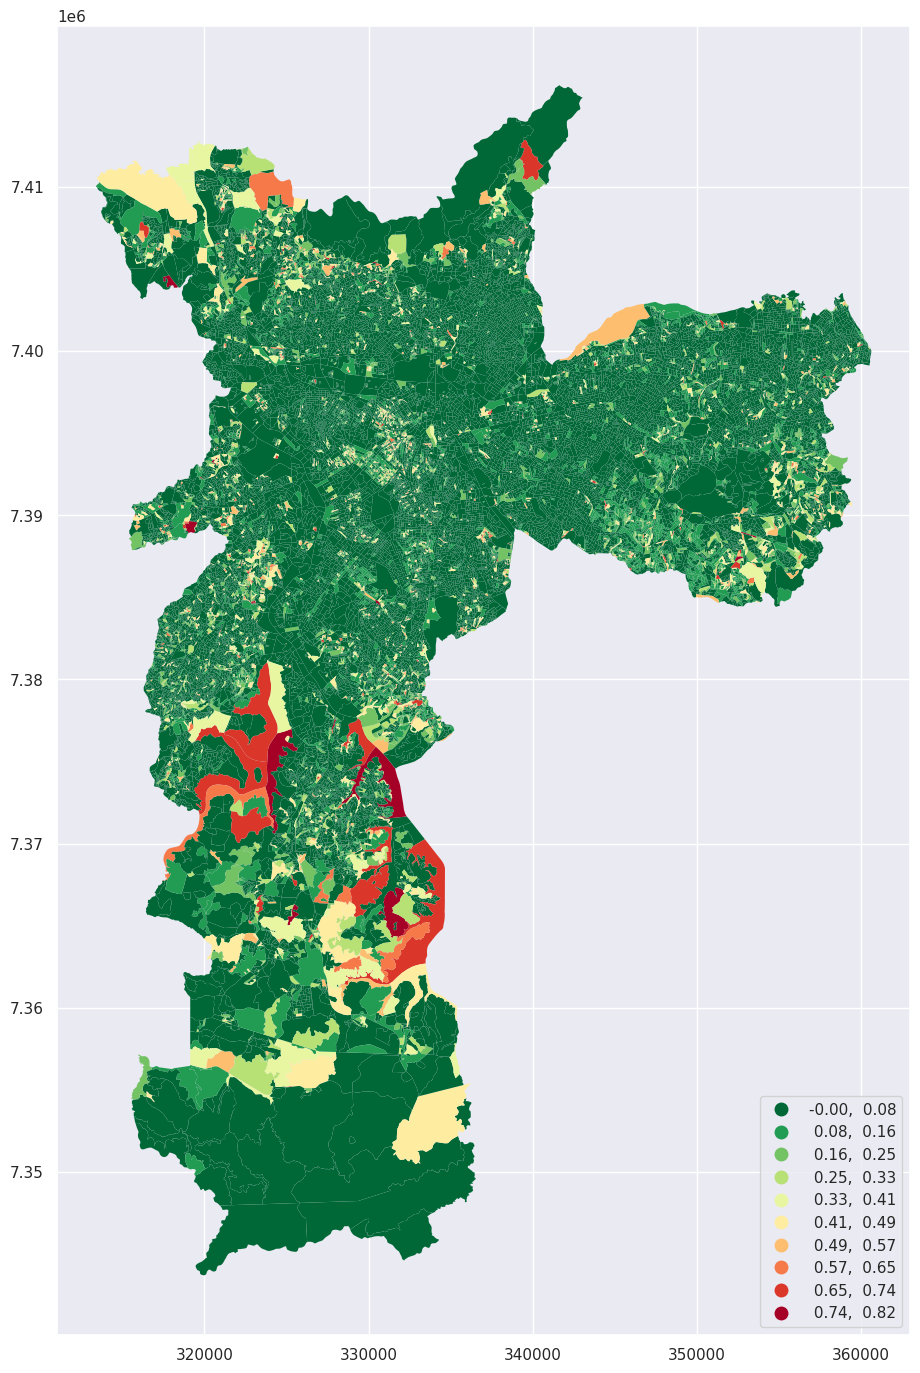

In [19]:
i_label, i_col = indexes[0]

gini_map = setores22.explore(
    tiles='CartoDB positron',
    column=i_col,
    # scheme='Quantiles',
    cmap='RdYlGn_r',
    legend=True,
    k=10, 
    tooltip=True,
    legend_kwds=dict(colorbar=True, scale=False),  # do not use colorbar
    # legend_kwds=dict(colorbar=False),
    name=i_label,
)

gini_map.save('plots/Gini_base.html')

gini_map = setores22.plot(
    column=i_col,
    scheme="equal_interval",
    k=10,
    cmap="RdYlGn_r",
    # edgecolor="k",
    linewidth=0.01,
    legend=True,
    legend_kwds={"loc": "lower right"},
    figsize=(14,17)
)

gini_map

<Axes: >

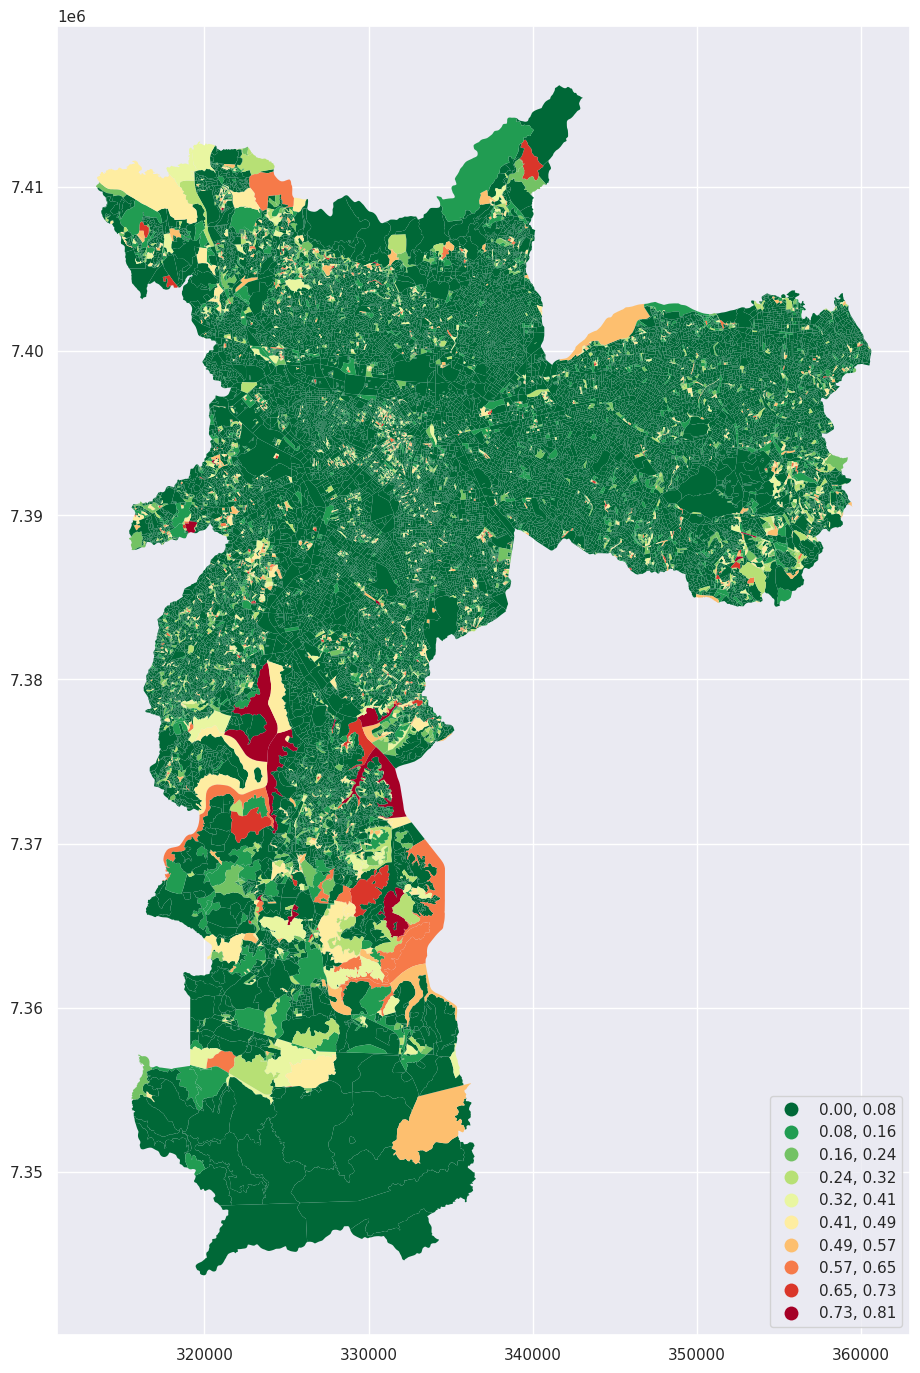

In [20]:
i_label, i_col = indexes[1]

# gini_map = setores22.explore(
#     tiles='CartoDB positron',
#     column=i_col,
#     # scheme='Quantiles',
#     cmap='RdYlGn_r',
#     legend=True,
#     k=10, 
#     tooltip=False,
#     # popup=['Distrito', 'População total (2010)', 'População total (2022)', 'Variação populacional (absoluta)', 'Variação populacional'],  # show popup (on-click)
#     legend_kwds=dict(colorbar=True, scale=False),  # do not use colorbar
#     # legend_kwds=dict(colorbar=False),
#     name=i_label,
# )

gini_map = setores22.plot(
    column=i_col,
    scheme="equal_interval",
    k=10,
    cmap="RdYlGn_r",
    # edgecolor="k",
    linewidth=0.01,
    legend=True,
    legend_kwds={"loc": "lower right"},
    figsize=(14,17)
)

gini_map

# Efeito colateral não previsto: setores censitários de 2022 "sem similaridade"

Alguns setores censitários de 2022, com variações em cada tipo de tratamento, não apresentaram similaridade com nenhum setor censitário de 2010 (o que causa estranhamento, visto que as dimensões do município se mantiveram).

Para entender melhor, vamos analisar esses setores.

In [21]:
inter_by_setor = sim_double_buff_22.groupby('CD_SETOR').count()
setores22['intersections'] = setores22['CD_SETOR'].apply(lambda i: 0 if i not in inter_by_setor.index else inter_by_setor.loc[i, 'CD_GEOCODI'])
setores22

,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,v0005,v0006,v0007,geometry,Gini_base,Gini_V,Gini_DB,Gini_DBR,Gini_base_centered,intersections
65763,355030801000001P,0.071797,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,2.359862,3.806228,289,"POLYGON ((339819.409 7392592.743, 339817.380 7...",0.02359,0.00158,-0.00000,0.00000,-0.069162,1
65764,355030801000002P,0.071902,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,2.293823,1.502504,599,"POLYGON ((339965.618 7393034.241, 339934.552 7...",0.05430,0.01627,0.00072,0.00072,-0.038452,2
65765,355030801000003P,0.055681,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,2.673171,9.268293,205,"POLYGON ((340157.893 7392942.288, 340105.133 7...",0.07598,0.01886,0.00003,0.00003,-0.016772,3
65766,355030801000004P,0.064905,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,2.380090,1.357466,221,"POLYGON ((339898.252 7392661.977, 339885.527 7...",0.09299,0.03326,0.00507,0.00507,0.000238,2
65767,355030801000005P,0.086820,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,2.619910,9.049774,221,"POLYGON ((339650.828 7392494.453, 339535.589 7...",0.15892,0.08442,0.04882,0.04882,0.066168,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93350,355030896000335P,0.073741,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,0.000000,0.000000,0,"POLYGON ((354132.481 7397368.586, 354125.016 7...",0.03266,0.03385,0.02150,0.02150,-0.060092,5
93351,355030896000336P,0.031251,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,2.960784,11.764706,204,"POLYGON ((354471.914 7396849.101, 354434.862 7...",0.14669,0.17425,0.15178,0.15178,0.053938,2
93352,355030896000337P,0.061406,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,0.000000,0.000000,0,"POLYGON ((354680.264 7397460.478, 354562.385 7...",0.19695,0.19828,0.17775,0.17775,0.104198,7
93353,355030896000338P,0.034111,3,Sudeste,35,São Paulo,3550308,São Paulo,355030896,Lajeado,...,3.052632,19.736842,152,"POLYGON ((355571.348 7397734.893, 355565.065 7...",0.02506,0.00912,0.00191,0.00191,-0.067692,2


In [22]:
setores22.query('intersections < 1')

,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,v0005,v0006,v0007,geometry,Gini_base,Gini_V,Gini_DB,Gini_DBR,Gini_base_centered,intersections
73561,355030830000747P,0.811273,3,Sudeste,35,São Paulo,3550308,São Paulo,355030830,Grajaú,...,0.000000,0.000000,0,"POLYGON ((333426.186 7370270.824, 333239.414 7...",0.00451,0.00000,0.0,0.0,-0.088242,0
78417,355030843000416P,0.346098,3,Sudeste,35,São Paulo,3550308,São Paulo,355030843,Jardim Ângela,...,0.000000,0.000000,0,"POLYGON ((323369.523 7373737.840, 323426.657 7...",-0.00000,0.00000,0.0,0.0,-0.092752,0
82008,355030855000643P,0.002977,3,Sudeste,35,São Paulo,3550308,São Paulo,355030855,Parelheiros,...,0.000000,0.000000,0,"POLYGON ((332300.903 7358834.600, 332284.988 7...",0.00072,0.00025,0.0,0.0,-0.092032,0


In [23]:
setores22['debuff'] = setores22.buffer(-2)

In [26]:
dists = setores22.query('intersections < 1').query('v0001 != "0"').loc[:, 'CD_DIST'].unique()

if len(dists) > 0:
    m = setores10.query('CD_GEOCODD in @dists').explore(
        name='Setores (2010)',  # name of the layer in the map
        color='darkred',
    )
    
    m = setores22.query('intersections < 1').query('v0001 != "0"').explore(
        m=m,
        name='Setores sem similaridade',
        color='royalblue',
        style_kwds={'fill': False},
    )
    
    m = setores22.query('intersections < 1').query('v0001 != "0"').debuff.explore(
        m=m,
        name='Setores sem similaridade',
        color='lightblue',
        style_kwds={'fill': False},
    )
    
    m

In [27]:
setores22.query('CD_SETOR == "355030825000340P"')

,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,v0006,v0007,geometry,Gini_base,Gini_V,Gini_DB,Gini_DBR,Gini_base_centered,intersections,debuff
71984,355030825000340P,0.077934,3,Sudeste,35,São Paulo,3550308,São Paulo,355030825,Cidade Tiradentes,...,0.000000,0,"POLYGON ((357612.363 7387754.389, 357627.598 7...",0.07746,0.07838,0.0,0.0,-0.015292,1,"POLYGON ((357611.045 7387755.897, 357563.870 7..."


In [28]:
dists = setores22.query('CD_SETOR == "355030825000340P"').loc[:, 'CD_DIST'].unique()

n = setores10.query('CD_GEOCODD in @dists').explore(
    name='Setores (2010)',  # name of the layer in the map
    color='darkred',
)

n = setores22.query('CD_SETOR == "355030825000340P"').explore(
    m=n,
    name='Setores sem similaridade',
    color='royalblue',
    style_kwds={'fill': False},
)

n = setores22.query('CD_SETOR == "355030825000340P"').debuff.explore(
    m=n,
    name='Setores sem similaridade',
    color='lightblue',
    style_kwds={'fill': False},
)

n